In [2]:
pip install yfinance matplotlib pandas numpy alpaca-trade-api

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import alpaca_trade_api as tradeapi

API_KEY = "your_alpaca_api_key"
SECRET_KEY = "your_alpaca_secret_key"
BASE_URL = "https://paper-api.alpaca.markets"

api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed
C:\Users\Admin\AppData\Local\Temp\ipykernel_45608\88866080.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol_threshold = vol_score.rolling(window=252).quantile(0.80).fillna(method='bfill')


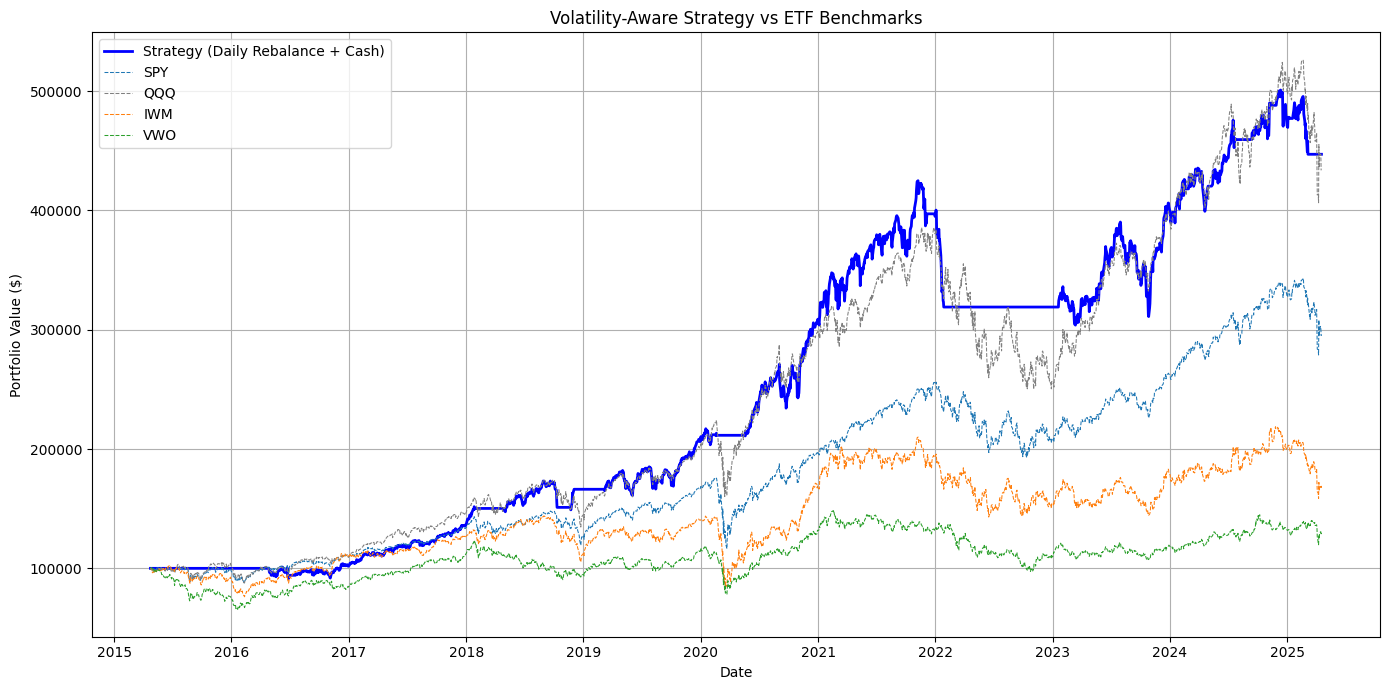


📊 Performance Summary:

         Cumulative Return Sharpe Ratio Max Drawdown
Strategy           347.01%         1.05      -28.49%
SPY                195.61%         0.69      -33.72%
QQQ                333.77%         0.77      -35.12%
IWM                 69.09%         0.35      -41.13%
VWO                 30.01%         0.23      -36.39%


C:\Users\Admin\AppData\Local\Temp\ipykernel_45608\88866080.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative = portfolio_series[-1] / portfolio_series[0] - 1


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#  Setup  
end_date = datetime.today()
start_date = end_date - timedelta(days=365 * 10)
tickers = ['QQQ', 'IWM', 'VWO', 'SPXL', 'SPY']
prices = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()

#  Signal Generation 
sma_50 = prices.rolling(window=50).mean()
sma_200 = prices.rolling(window=200).mean()
signals = (sma_50 > sma_200).astype(int)

strategy_etfs = ['QQQ', 'IWM', 'VWO', 'SPXL']
strategy_signals = signals[strategy_etfs]

# Daily Rebalancing Weights Based on Signals 
weights = strategy_signals.div(strategy_signals.sum(axis=1), axis=0).fillna(0)

#  Volatility Scoring 
returns = prices.pct_change().fillna(0)
volatility = returns[strategy_etfs].rolling(window=20).std()
vol_score = volatility.mean(axis=1)
vol_threshold = vol_score.rolling(window=252).quantile(0.80).fillna(method='bfill')

#  Volatility-Aware Allocation 
adjusted_weights = weights.copy()
adjusted_weights[vol_score > vol_threshold] = 0  # rotate to cash during high vol

#  Portfolio Simulation 
portfolio_returns = (returns[strategy_etfs] * adjusted_weights).sum(axis=1)
portfolio_value = (1 + portfolio_returns).cumprod() * 100000

#  Benchmark Portfolios: Buy & Hold 
spy_returns = returns['SPY']
spy_portfolio_value = (1 + spy_returns).cumprod() * 100000
qqq_value = (1 + returns['QQQ']).cumprod() * 100000
iwm_value = (1 + returns['IWM']).cumprod() * 100000
vwo_value = (1 + returns['VWO']).cumprod() * 100000

#  Portfolio Value Comparison 
plt.figure(figsize=(14, 7))
plt.plot(portfolio_value, label='Strategy (Daily Rebalance + Cash)', color='blue', linewidth=2.0)
plt.plot(spy_portfolio_value, label='SPY', linestyle='--', linewidth=0.75)
plt.plot(qqq_value, label='QQQ', color='gray', linestyle='--', linewidth=0.75)
plt.plot(iwm_value, label='IWM', linestyle='--', linewidth=0.75)
plt.plot(vwo_value, label='VWO', linestyle='--', linewidth=0.75)
plt.title('Volatility-Aware Strategy vs ETF Benchmarks')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Performance Metric 
def get_metrics(portfolio_series, returns_series):
    cumulative = portfolio_series[-1] / portfolio_series[0] - 1
    sharpe = returns_series.mean() / returns_series.std() * np.sqrt(252)
    drawdown = ((portfolio_series / portfolio_series.cummax()) - 1).min()
    return [f"{cumulative:.2%}", f"{sharpe:.2f}", f"{drawdown:.2%}"]

#  Summary 
metrics = {
    "Strategy": get_metrics(portfolio_value, portfolio_returns),
    "SPY": get_metrics(spy_portfolio_value, returns['SPY']),
    "QQQ": get_metrics(qqq_value, returns['QQQ']),
    "IWM": get_metrics(iwm_value, returns['IWM']),
    "VWO": get_metrics(vwo_value, returns['VWO']),
}

summary_df = pd.DataFrame(metrics, index=["Cumulative Return", "Sharpe Ratio", "Max Drawdown"]).T

#  Print Summary Table 
print("\n📊 Performance Summary:\n")
print(summary_df)

In [190]:
pip install yfinance matplotlib pandas numpy alpaca-trade-api schedule pytz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta
import schedule
import time
from pytz import timezone

#  Strategy Configuration 
tickers = ['QQQ', 'IWM', 'VWO']
initial_cash = 100000
allocation_threshold = 0.80  # top 20% volatility triggers cash

#  Signal & Weight Generation 
def get_signals_and_weights():
    end = datetime.today()
    start = end - timedelta(days=365 * 10)
    data = yf.download(tickers, start=start, end=end)['Close'].dropna()

    sma_50 = data.rolling(window=50).mean()
    sma_200 = data.rolling(window=200).mean()
    signals = (sma_50 > sma_200).astype(int)

    weights = signals.div(signals.sum(axis=1), axis=0).fillna(0)
    latest_weights = weights.iloc[-1]

    returns = data.pct_change().fillna(0)
    vol = returns[tickers].rolling(window=20).std()
    vol_score = vol.mean(axis=1)
    vol_threshold = vol_score.rolling(window=252).quantile(allocation_threshold).bfill()

    # Volatility check
    if vol_score.iloc[-1] > vol_threshold.iloc[-1]:
        latest_weights[:] = 0  # rotate to cash

    return latest_weights

#  Portfolio Rebalancing 
def rebalance_portfolio():
    print("\n📈 Rebalancing Portfolio:", datetime.now())

    weights = get_signals_and_weights()
    account = api.get_account()
    equity = float(account.equity)

    # Cancel open orders
    open_orders = api.list_orders(status='open')
    for order in open_orders:
        api.cancel_order(order.id)

    # Liquidate positions if cash rotation
    if weights.sum() == 0:
        positions = api.list_positions()
        for pos in positions:
            side = 'sell' if float(pos.qty) > 0 else 'buy'
            api.submit_order(
                symbol=pos.symbol,
                qty=abs(int(float(pos.qty))),
                side=side,
                type='market',
                time_in_force='day'
            )
        print("🔁 Rotated to cash due to high volatility.")
        return

    # Place new orders based on weights
    for symbol, weight in weights.items():
        if weight > 0:
            price = float(api.get_latest_trade(symbol).price)
            qty = int((equity * weight) // price)

            if qty > 0:
                api.submit_order(
                    symbol=symbol,
                    qty=qty,
                    side='buy',
                    type='market',
                    time_in_force='day'
                )
                print(f"✅ Buy {qty} shares of {symbol} at ~${price:.2f} ({weight:.1%})")

    print("\n💰 Current Account Equity:", equity)
    print("\n📋 Open Positions:")
    for pos in api.list_positions():
        print(f" - {pos.symbol}: {pos.qty} shares @ ${pos.current_price}")

#  Schedule to Run Weekdays at 10:00 AM EST 
def is_market_open():
    try:
        return api.get_clock().is_open
    except:
        return False

def job():
    if is_market_open():
        rebalance_portfolio()
    else:
        print("Market is closed. No rebalance today.")

schedule.every().monday.at("10:00").do(job)
schedule.every().tuesday.at("10:00").do(job)
schedule.every().wednesday.at("10:00").do(job)
schedule.every().thursday.at("10:00").do(job)
schedule.every().friday.at("10:00").do(job)

# Loop 
print("📅 Rebalance bot is running... Waiting for market open.")
while True:
    schedule.run_pending()
    time.sleep(60)

📅 Rebalance bot is running... Waiting for market open.
